In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Data Retrieval

### Load Data

In [36]:
# The target variable is loaded in two versions:
df_Y_complete = pd.read_csv('data/complete_target.csv', index_col=0, parse_dates=True)
df_Y_target = pd.read_csv('data/target.csv', index_col=0, parse_dates=True) # Short version

# Exogenous Variables
df_X_ppi = pd.read_csv('data/ppi.csv', index_col=0, parse_dates=True)
df_X_unemp = pd.read_csv('data/Unemployment.csv', index_col=0, parse_dates=True)
df_X_oil = pd.read_csv('data/brent.csv', index_col=0, parse_dates=True)
df_X_cli = pd.read_csv('data/cli.csv', index_col=0, parse_dates=True)

# Rename columns for clarity and consistency
df_Y_complete.columns = ['Y_IPI_Level']
df_Y_target.columns = ['Y_IPI_Level'] # Note: 'target' is the same series as the tail of 'complete_target'
df_X_ppi.columns = ['X_PPI_Level'] # NSA Index/Level required for Delta_12
df_X_unemp.columns = ['X_UNEMP_Level']
df_X_oil.columns = ['X_OIL_Level']
df_X_cli.columns = ['X_CLI_Level']

In [37]:
# All data is merged to the latest start date (Jan 2000 constraint)
df_aligned = df_Y_target.join([df_X_ppi, df_X_unemp, df_X_oil, df_X_cli], how='inner').dropna()

df_aligned

,Y_IPI_Level,X_PPI_Level,X_UNEMP_Level,X_OIL_Level,X_CLI_Level
observation_date,,,,,
2000-02-01,125.7063,100.00000,9.3,28.030476,101.543688
2000-03-01,126.7591,152.77636,9.2,27.494348,101.637662
2000-04-01,127.7066,-9.95472,9.1,23.153500,101.705034
2000-05-01,128.4436,142.47794,9.0,27.805217,101.743914
2000-06-01,128.2330,99.61640,9.0,30.483182,101.755679
...,...,...,...,...,...
2022-07-01,104.7552,620.71030,6.7,105.252857,99.208340
2022-08-01,107.2820,405.96384,6.7,97.643043,98.976413
2022-09-01,104.7552,399.96746,6.7,90.608182,98.782849


### Visualization of target data (Both complete and limited for exogenous variables)

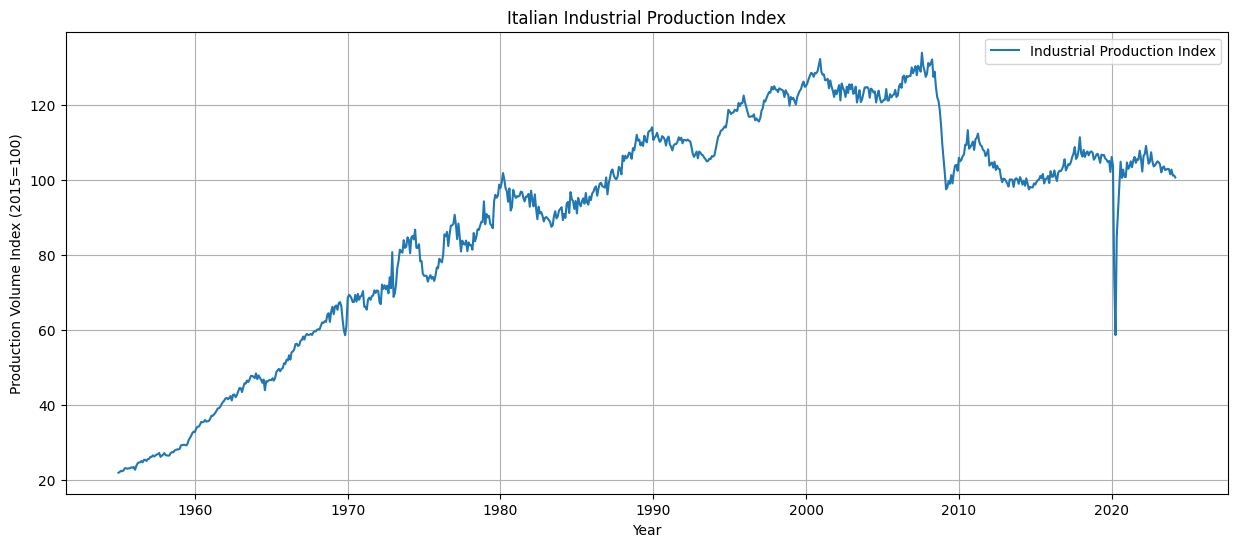

In [38]:
# Visualize initial time series
plt.figure(figsize=(15,6))
plt.plot(df_Y_complete.index, df_Y_complete['Y_IPI_Level'], label='Industrial Production Index')
plt.title('Italian Industrial Production Index')
plt.xlabel('Year')
plt.ylabel('Production Volume Index (2015=100)')
plt.legend()
plt.grid(True)
plt.show()

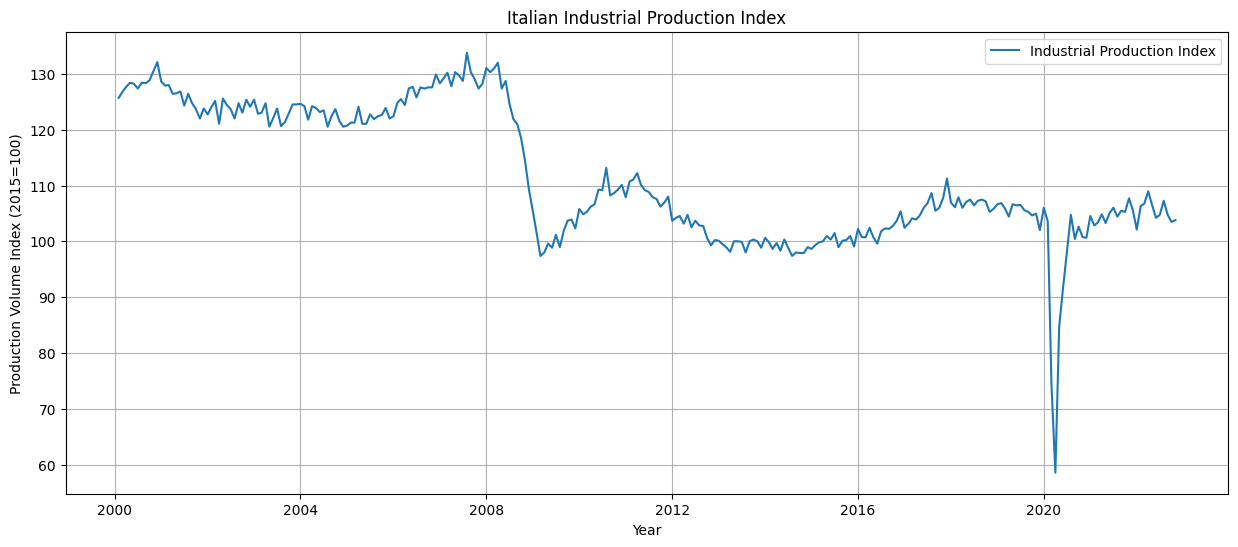

In [39]:
# Visualize initial time series
plt.figure(figsize=(15,6))
plt.plot(df_Y_target.index, df_Y_target['Y_IPI_Level'], label='Industrial Production Index')
plt.title('Italian Industrial Production Index')
plt.xlabel('Year')
plt.ylabel('Production Volume Index (2015=100)')
plt.legend()
plt.grid(True)
plt.show()

we notice that limiting the dataset for adherence with the exogenous variable we don't have the clear increasing trend in the data and we have to tackle the difficulties emerging from the 2008 and 2020 crisis

# Stationarity Check

### Test stationarity before differencing

In [40]:
# --- Prepare Log-Level/Level Series for Testing ---
series_to_test = {
    'Y_IPI (Log-Level)': np.log(df_aligned['Y_IPI_Level']),
    'X_PPI (Log-Level)': np.log(df_aligned['X_PPI_Level']),
    'X_OIL (Log-Level)': np.log(df_aligned['X_OIL_Level']),
    'X_UNEMP (Level)': df_aligned['X_UNEMP_Level'],
    'X_CLI (Log-Level)': np.log(df_aligned['X_CLI_Level']),
}


# Function for ADF test (re-defined here for integration)
def run_adf_test(series, name):
    print(f"--- ADF Test for {name} ---")
    # Using 'ct' (constant and trend) for the IPI, PPI, Oil (prices/indices with trend)
    # Using 'c' (constant only) for Unemployment, CLI (ratios/indicators that might not have a strong trend)
    if 'UNEMP' in name or 'CLI' in name:
        regression_type = 'c'
    else:
        regression_type = 'ct'
        
    result = adfuller(series, regression=regression_type)
    print(f'ADF Statistic: {result[0]:.4f}')
    print(f'p-value: {result[1]:.4f}')
    
    cv_5_percent = result[4]['5%']
    print(f'Critical Value (5%): {cv_5_percent:.4f}')

    # Check for I(1) status
    if result[0] < cv_5_percent:
        print(f"Conclusion: Reject H0. Series is **Stationary** (Justifies stopping at I(0)).")
    else:
        print(f"Conclusion: Fail to Reject H0. Series is **Non-Stationary (I(1))** (Justifies Differencing).")
    print("-" * 40)


# --- Execute Diagnostics for all 5 Series ---
print("\n" + "=" * 60)
print("PRE-TRANSFORMATION DIAGNOSTIC (Target and Exogenous Variables)")
print("=" * 60)

for name, series in series_to_test.items():
    run_adf_test(series.dropna(), name)

print("=" * 60)


PRE-TRANSFORMATION DIAGNOSTIC (Target and Exogenous Variables)
--- ADF Test for Y_IPI (Log-Level) ---
ADF Statistic: -2.9713
p-value: 0.1403
Critical Value (5%): -3.4269
Conclusion: Fail to Reject H0. Series is **Non-Stationary (I(1))** (Justifies Differencing).
----------------------------------------
--- ADF Test for X_PPI (Log-Level) ---
ADF Statistic: -4.5398
p-value: 0.0013
Critical Value (5%): -3.4354
Conclusion: Reject H0. Series is **Stationary** (Justifies stopping at I(0)).
----------------------------------------
--- ADF Test for X_OIL (Log-Level) ---
ADF Statistic: -2.5548
p-value: 0.3011
Critical Value (5%): -3.4268
Conclusion: Fail to Reject H0. Series is **Non-Stationary (I(1))** (Justifies Differencing).
----------------------------------------
--- ADF Test for X_UNEMP (Level) ---
ADF Statistic: -1.6563
p-value: 0.4537
Critical Value (5%): -2.8726
Conclusion: Fail to Reject H0. Series is **Non-Stationary (I(1))** (Justifies Differencing).
------------------------------

/Users/paolominini/Desktop/Università/Time Series Forecast/Time-Series-Project/.venv/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


The ADF tests confirm our expectation that the IPI, Oil, and Unemployment levels are indeed Non-Stationary ($I(1)$), justifying our planned differencing.

However, the PPI and CLI provide a surprise:
- Italy PPI (Log-Level): The ADF Stat (-4.54) is less than the CV (-3.44), and the $p$-value is very low (0.0013). 
This formally indicates the log-level is already Stationary ($I(0)$).

- OECD CLI (Log-Level): The ADF Stat (-4.15) is less than the CV (-2.87), and the $p$-value is very low (0.0008). 
This formally indicates the log-level is already Stationary ($I(0)$).

This means our planned transformations for PPI and CLI were technically unnecessary for stationarity, but still crucial for other reasons:
- PPI ($\mathbf{X_{t,1}}$): We must use the Year-over-Year Log-Difference ($\Delta_{12} \ln$) because the series is NSA. Even if the level is technically $I(0)$ now, the raw data still contains seasonal contamination, which $\Delta_{12} \ln$ correctly removes

- CLI ($\mathbf{X_{t,4}}$): While technically stationary in level, we should use the First Difference ($\Delta \ln$) to ensure all explanatory variables are modeled in terms of changes (momentum/growth), aligning them logically with our $\Delta \ln Y_t$ target.

### Apply Transformations

In [41]:
df_final = pd.DataFrame(index=df_aligned.index)

# A. Target Variable (Y_IPI) - SA Index
# Transformation: MoM Log-Difference (Delta Log) for I(0)
df_final['DLOG.Y_IPI'] = np.log(df_aligned['Y_IPI_Level']).diff(1).dropna()

# B. Exogenous PPI (X_PPI) - NSA Index
# Transformation: YoY Log-Difference (Delta 12 Log) for non-seasonal I(0)
df_final['D12LOG.X_PPI'] = np.log(df_aligned['X_PPI_Level']).diff(12).dropna()

# C. Exogenous Unemployment (X_UNEMP) - SA Ratio
# Transformation: First Difference (Delta) for I(0)
df_final['D.X_UNEMP'] = df_aligned['X_UNEMP_Level'].diff(1).dropna()

# D. Exogenous Oil (X_OIL) - NSA Price
# Transformation: MoM Log-Difference (Delta Log) for I(0)
df_final['DLOG.X_OIL'] = np.log(df_aligned['X_OIL_Level']).diff(1).dropna()

# E. Exogenous CLI (X_CLI) - SA Index
# Transformation: MoM Log-Difference (Delta Log) for I(0) (CLI is often I(0) in level but we difference for caution)
df_final['DLOG.X_CLI'] = np.log(df_aligned['X_CLI_Level']).diff(1).dropna()


/Users/paolominini/Desktop/Università/Time Series Forecast/Time-Series-Project/.venv/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [ ]:
df_final = df_final.dropna() # Drop all leading NaNs from differencing (max 12 rows lost)

N_OBS = len(df_final)
N_TEST = int(N_OBS * 0.20)
TRAIN_END_INDEX = N_OBS - N_TEST

df_train = df_final.iloc[:TRAIN_END_INDEX]
df_test = df_final.iloc[TRAIN_END_INDEX:]

print("--- Data Preparation Summary ---")
print(f"Final Aligned Sample Start: {df_final.index.min().strftime('%Y-%m')}")
print(f"Final Aligned Sample End: {df_final.index.max().strftime('%Y-%m')}")
print(f"Total Observations (T): {N_OBS}")
print(f"Training Set End: {df_train.index.max().strftime('%Y-%m')} ({len(df_train)} obs)")
print(f"Test Set Start: {df_test.index.min().strftime('%Y-%m')} ({len(df_test)} obs)")
print("-" * 40)
print("Transformed Data Head:")
print(df_final.head())

# Store key DFs globally for subsequent steps
df_project_working = df_final
df_Y_full_level = df_Y_complete.join(df_X_ppi['X_PPI_Level'], how='inner').dropna()

# --- 5. Structural Bias Test Preparation (SBT) ---
# Prepare the target series for the SBT (Univariate model on Full Sample)
# SBT target is the full IPI history, which we will analyze separately in Step 1.4.
df_SBT_target = df_Y_complete[df_Y_complete.index <= df_Y_target.index.max()].dropna()

--- Data Preparation Summary ---
Final Aligned Sample Start: 2001-02
Final Aligned Sample End: 2022-11
Total Observations (T): 114
Training Set End: 2019-09 (92 obs)
Test Set Start: 2019-10 (22 obs)
----------------------------------------
Transformed Data Head:
                  DLOG.Y_IPI  D12LOG.X_PPI  D.X_UNEMP  DLOG.X_OIL  DLOG.X_CLI
observation_date                                                             
2001-02-01         -0.005744     -1.385847       -0.1    0.078514   -0.002299
2001-03-01          0.000823     -3.150327        0.0   -0.108245   -0.002383
2001-06-01          0.002493     -3.100682        0.0   -0.015395   -0.002279
2001-09-01         -0.013412     -4.289909        0.0    0.003913   -0.001687
2002-01-01         -0.008540      0.158357        0.0    0.069853    0.001055


In [45]:
print("\n" + "=" * 60)
print("Formal ADF Unit Root Tests on Transformed (I(0) Candidate) Series")
print("=" * 60)
for col in df_project_working.columns:
    run_adf_test(df_project_working[col], col)
print("=" * 60)


Formal ADF Unit Root Tests on Transformed (I(0) Candidate) Series
--- ADF Test for DLOG.Y_IPI ---
ADF Statistic: -13.2941
p-value: 0.0000
Critical Value (5%): -3.4501
Conclusion: Reject H0. Series is **Stationary** (Justifies stopping at I(0)).
----------------------------------------
--- ADF Test for D12LOG.X_PPI ---
ADF Statistic: -5.0569
p-value: 0.0002
Critical Value (5%): -3.4508
Conclusion: Reject H0. Series is **Stationary** (Justifies stopping at I(0)).
----------------------------------------
--- ADF Test for D.X_UNEMP ---
ADF Statistic: -3.0510
p-value: 0.0304
Critical Value (5%): -2.8890
Conclusion: Reject H0. Series is **Stationary** (Justifies stopping at I(0)).
----------------------------------------
--- ADF Test for DLOG.X_OIL ---
ADF Statistic: -9.7796
p-value: 0.0000
Critical Value (5%): -3.4501
Conclusion: Reject H0. Series is **Stationary** (Justifies stopping at I(0)).
----------------------------------------
--- ADF Test for DLOG.X_CLI ---
ADF Statistic: -3.6310


**Now all the series used are stationary**

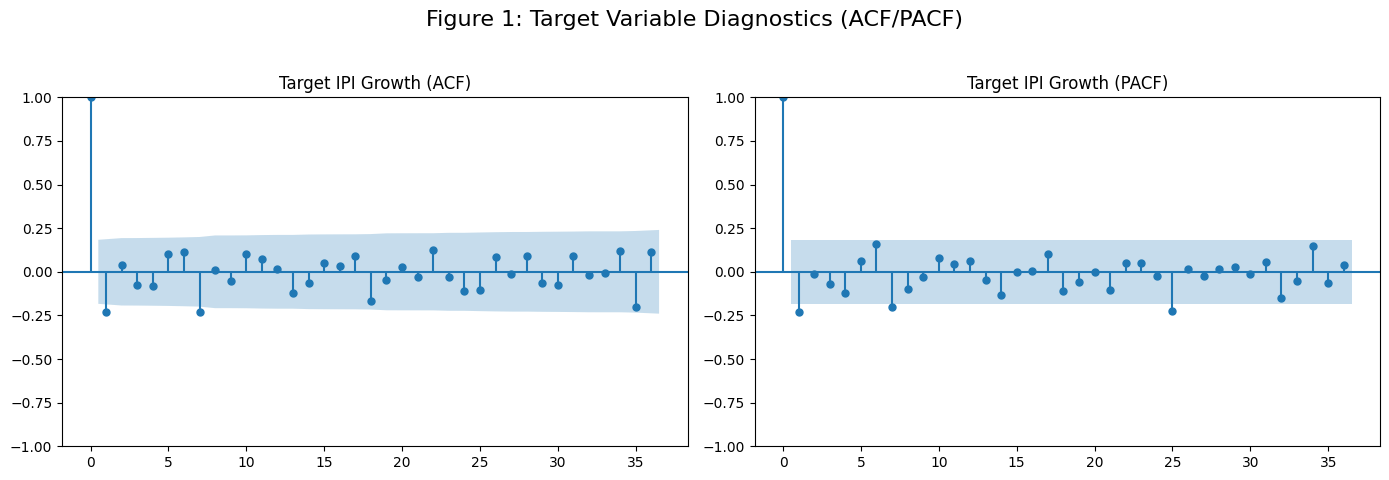

In [46]:
Lags = 36 # Check up to 3 years of lags

#  ACF/PACF of the target variable

fig1, axes1 = plt.subplots(1, 2, figsize=(14, 5))
plt.suptitle('Figure 1: Target Variable Diagnostics (ACF/PACF)', fontsize=16)

plot_acf(df_final['DLOG.Y_IPI'], lags=Lags, ax=axes1[0], title='Target IPI Growth (ACF)')
plot_pacf(df_final['DLOG.Y_IPI'], lags=Lags, method='ywm', ax=axes1[1], title='Target IPI Growth (PACF)')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show(fig1)

#  ACF/PACF of the exogenous variable

fig2, axes2 = plt.subplots(4, 2, figsize=(14, 18))
plt.suptitle('Figure 2: Exogenous Variables Diagnostics (ACF/PACF)', fontsize=16)

# Row 1: PPI (YoY) - CHECK FOR SEASONALITY
plot_acf(df_final['D12LOG.X_PPI'], lags=Lags, ax=axes2[0, 0], title='PPI YoY Growth (ACF)')
plot_pacf(df_final['D12LOG.X_PPI'], lags=Lags, method='ywm', ax=axes2[0, 1], title='PPI YoY Growth (PACF)')

# Row 2: Unemployment (Difference) - CHECK FOR AR/MA STRUCTURE
plot_acf(df_final['D.X_UNEMP'], lags=Lags, ax=axes2[1, 0], title='Unemployment Diff (ACF)')
plot_pacf(df_final['D.X_UNEMP'], lags=Lags, method='ywm', ax=axes2[1, 1], title='Unemployment Diff (PACF)')

# Row 3: Oil Price (Growth) - CHECK FOR AR/MA STRUCTURE
plot_acf(df_final['DLOG.X_OIL'], lags=Lags, ax=axes2[2, 0], title='Oil Price Growth (ACF)')
plot_pacf(df_final['DLOG.X_OIL'], lags=Lags, method='ywm', ax=axes2[2, 1], title='Oil Price Growth (PACF)')

# Row 4: CLI (Growth) - CHECK FOR AR/MA STRUCTURE
plot_acf(df_final['DLOG.X_CLI'], lags=Lags, ax=axes2[3, 0], title='CLI Growth (ACF)')
plot_pacf(df_final['DLOG.X_CLI'], lags=Lags, method='ywm', ax=axes2[3, 1], title='CLI Growth (PACF)')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.close(fig2) #change close to show to visualize the ACF/PACF of exogenous variables

**For the target variable:** 

The ACF shows a significant spike at Lag 1 but quickly drops to zero and stays within the confidence bands for nearly all subsequent lags. The Lags 6-7 and 12-13 spikes appear marginally significant but are likely noise.

- The sharp cutoff after Lag 1 suggests a Moving Average process of order 1, MA(1)."

The PACF shows a significant spike at Lag 1 and then tails off slowly (few decaying spikes beyond the confidence limits, e.g., Lags 2, 7, 25).
- The slow decay suggests an Autoregressive process of infinite order, AR(∞)."

# Benchmark selection

In [52]:
target_series_train = df_train['DLOG.Y_IPI']

In [ ]:

best_aic = np.inf
best_bic = np.inf
best_order_aic = None
best_order_bic = None
arima_results = {}

# Candidate orders based on ACF/PACF (p, d=0, q) #d=0 because we already differentiated the time series
candidate_orders = [
    (1, 0, 0), # AR(1)
    (0, 0, 1), # MA(1)
    (1, 0, 1), # ARMA(1,1)
    (2, 0, 0), # AR(2)
    (0, 0, 2)  # MA(2)
]

for p, d, q in candidate_orders:
    try:
        # Fit on the training portion of the stationary data
        model = ARIMA(target_series_train, order=(p, d, q), trend='c') 
        model_fit = model.fit()
        
        aic = model_fit.aic
        bic = model_fit.bic
        
        arima_results[(p, d, q)] = {'aic': aic, 'bic': bic}
        
        if aic < best_aic:
            best_aic = aic
            best_order_aic = (p, d, q)
            
            
        if bic < best_bic:
            best_bic = bic
            best_order_bic = (p, d, q)

    except Exception:
        continue

# --- Display Selection Results ---

print("\n" + "=" * 60)
print("PRIMARY BENCHMARK SELECTION (Short Sample: DLOG.Y_IPI)")
print("=" * 60)

results_df = pd.DataFrame.from_dict(arima_results, orient='index')
results_df = results_df.sort_values(by='aic')
print(results_df.round(2))

print("\n--- Final Selected Structure ---")
print(f"AIC Best Model: ARIMA{best_order_aic} (AIC: {best_aic:.2f})")
print(f"BIC Best Model: ARIMA{best_order_bic} (BIC: {best_bic:.2f})")
print(f"Primary Benchmark Structure: ARIMA{best_order_aic}")
print("=" * 60)


PRIMARY BENCHMARK SELECTION (Short Sample: DLOG.Y_IPI)
          aic     bic
1 0 0 -507.92 -500.36
0 0 1 -507.02 -499.45
    2 -506.43 -496.35
2 0 0 -506.01 -495.93
1 0 1 -505.97 -495.88

--- Final Selected Structure ---
AIC Best Model: ARIMA(1, 0, 0) (AIC: -507.92)
BIC Best Model: ARIMA(1, 0, 0) (BIC: -500.36)
**Primary Benchmark Structure: ARIMA(1, 0, 0)


/Users/paolominini/Desktop/Università/Time Series Forecast/Time-Series-Project/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/paolominini/Desktop/Università/Time Series Forecast/Time-Series-Project/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/paolominini/Desktop/Università/Time Series Forecast/Time-Series-Project/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/paolominini/Deskto

In [55]:
model = ARIMA(target_series_train, order=best_order_aic, trend='c')
BENCHMARK_FIT = model.fit()

# Print the full estimation summary
print("=" * 70)
print(f"ESTIMATION SUMMARY: PRIMARY BENCHMARK (ARIMA{best_order_aic} on DLOG.Y_IPI)")
print("-" * 70)
print(BENCHMARK_FIT.summary())
print("=" * 70)

ESTIMATION SUMMARY: PRIMARY BENCHMARK (ARIMA(1, 0, 0) on DLOG.Y_IPI)
----------------------------------------------------------------------
                               SARIMAX Results                                
Dep. Variable:             DLOG.Y_IPI   No. Observations:                   92
Model:                 ARIMA(1, 0, 0)   Log Likelihood                 256.962
Date:                Tue, 18 Nov 2025   AIC                           -507.923
Time:                        18:46:23   BIC                           -500.358
Sample:                             0   HQIC                          -504.870
                                 - 92                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0007      0.001     -0.507      0.612      -0.003    

/Users/paolominini/Desktop/Università/Time Series Forecast/Time-Series-Project/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/paolominini/Desktop/Università/Time Series Forecast/Time-Series-Project/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/paolominini/Desktop/Università/Time Series Forecast/Time-Series-Project/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


### Structural Bias Test

The full IPI Level series starts much earlier than 2000. We prepare the non-differenced, full history log-level for this test. 
We use the Level series for this test for clarity in demonstration.